In [1]:
import pandas as pd
import numpy as np

In [2]:
def read_jsonl(fname):
    df = pd.read_json(
        fname,
        lines=True
    )
    df = df.astype({
        "charset": "category",
    }, copy=False)
    if "unknown" in df["charset"].cat.categories:
        df["charset"].replace("unknown", np.nan, inplace=True)
        df["charset"].cat.remove_categories(["unknown"])
    df.set_index("url", inplace=True)
    df.query('~index.duplicated()', inplace=True) # Remove duplicates
    return df

In [3]:
df = pd.concat([
    read_jsonl(f"segment_big_{name}_charsets.jsonl.xz")["charset"].rename(name)
    for name in ("standard", "standard_noparse", "default", "icu", "chrome")
], axis=1, sort=True).rename_axis("url")

In [4]:
charset_counts = df.apply(pd.Series.value_counts).sum(axis=1).sort_values(ascending=False)
ordered_charsets = charset_counts[charset_counts>0].index
for c in df.columns: df[c].cat.set_categories(ordered_charsets, ordered=True, inplace=True)

ordered_charsets

CategoricalIndex(['UTF-8', 'windows-1252', 'ISO-8859-1', 'GBK', 'ISO-8859-15',
                  'windows-1251', 'GB18030', 'GB2312', 'windows-1250',
                  'Shift_JIS', 'windows-1256', 'ISO-8859-2', 'EUC-JP',
                  'windows-1254', 'Big5', 'ISO-8859-9', 'windows-1255',
                  'EUC-KR', 'windows-1257', 'US-ASCII', 'x-windows-874',
                  'windows-874', 'TIS-620', 'ISO-8859-7', 'KOI8-R', 'UTF-16LE',
                  'ISO-8859-5', 'ISO-8859-13', 'ISO-8859-4', 'ISO-8859-3',
                  'ISO-8859-8', 'UTF-16', 'KOI8-U', 'ISO-8859-16',
                  'windows-1253', 'x-MacCyrillic', 'gb18030', 'ISO-8859-8-I',
                  'ISO-8859-10', 'IBM866', 'IBM500', 'ISO-8859-6',
                  'windows-31j'],
                 categories=['Big5', 'EUC-JP', 'EUC-KR', 'GB18030', 'GB2312', 'GBK', 'IBM500', 'IBM866', ...], ordered=False, dtype='category')

In [5]:
known = df.dropna()
known.sample(5)

,standard,standard_noparse,default,icu,chrome
url,,,,,
http://www.prontointervento.eu/tag/pronto-intervento-fabbro-affori-milano/,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8
http://www.lesfoodies.com/amariaf,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8
https://www.handinglove.co.uk/Anitek/FrankJWilson/FrankJWilson/,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8
http://malina.od.ua/search/offset120/?direction=ASC&searchtag=Fabiano&sort=customers_rating&tag=Fabiano,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8
http://bmw.partswebsite.com/2003-bmw-x5-4.4i-gas_4.4_v_8-transmission_automatic_4-parts/,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8


In [6]:
(known.chrome == known.standard).sum() / len(known)

0.993680004610331

In [7]:
(known.chrome == known.default).sum() / len(known)

0.859288856445819

In [8]:
known.query("standard!=chrome").groupby(by=["standard", "chrome"]).count().sort_values(by="default", ascending=False).query("default>10")

,,standard_noparse,default,icu
standard,chrome,,,
UTF-8,windows-1252,420.0,420.0,420.0
windows-1252,UTF-8,79.0,79.0,79.0
x-windows-874,windows-874,37.0,37.0,37.0
ISO-8859-2,windows-1252,24.0,24.0,24.0
windows-1252,GBK,17.0,17.0,17.0
GB18030,GBK,14.0,14.0,14.0


In [9]:
similar_charsets = {
 'ISO-8859-1': 'windows-1252',
 'ISO-8859-15': 'windows-1252',
 'US-ASCII': 'windows-1252',
 'GB2312': 'GBK',
 'GB18030': 'GBK',
 'ISO-8859-9': 'windows-1254'
}

In [10]:
known_similar = known.replace(
    ["ISO-8859-1", "ISO-8859-15", "US-ASCII"], "windows-1252"
).replace(
    ["GB2312", "GB18030", "gb18030"], "GBK"
).replace(
 ['ISO-8859-9'], 'windows-1254'
)
known_similar.sample(5)

,standard,standard_noparse,default,icu,chrome
url,,,,,
http://radioultra.bg/index.php?Itemid=73&id=269&option=com_content&task=view,windows-1251,windows-1251,windows-1251,windows-1252,windows-1251
http://www.hottestpornmovies.com/categories/Shaved/,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8
https://www.pornohammer.com/videos/frauenarzt-untersucht-die-hure-auf-andere-art-6587/,UTF-8,UTF-8,UTF-8,UTF-8,UTF-8
http://zeme.sopka.cz/zeme_kapitola.php?idZeme=156&klic=1174,windows-1250,windows-1250,windows-1250,windows-1252,windows-1250
http://www.tuingerei.nl/brand/elephant?page=24,windows-1252,windows-1252,UTF-8,windows-1252,windows-1252


In [11]:
len(known_similar)
len(known)

104114

In [12]:
(known_similar.chrome == known_similar.default).sum() / len(known_similar)

0.9744510824672955

In [13]:
(known_similar.chrome == known_similar.standard).sum() / len(known_similar)

0.9938528920222064

In [14]:
known_similar.query("chrome==default & chrome != standard")

,standard,standard_noparse,default,icu,chrome
url,,,,,
http://1stbn4thmarines.net/h&S-company/roll/h.htm,UTF-8,UTF-8,windows-1252,UTF-8,windows-1252
http://animalhealthdigest.com/managing-the-skinny-older-horse/,UTF-8,UTF-8,windows-1252,UTF-8,windows-1252
http://astroa.physics.metu.edu.tr/twn/n2237.html,ISO-8859-2,ISO-8859-2,windows-1252,ISO-8859-2,windows-1252
http://aupairjapanese.com/?p=3608,UTF-8,UTF-8,windows-1252,UTF-8,windows-1252
http://backtonatureusa.com/index.php?cPath=3872&main_page=index&zenid=4b0ed213449e2b2b3fa6f56f884d07ab,UTF-8,UTF-8,windows-1252,UTF-8,windows-1252
http://barbaraassiff.yourkwagent.com/atj/user/AboutUsGetAction.do,UTF-8,UTF-8,windows-1252,UTF-8,windows-1252
http://bebbdg.cltvc.com/,windows-1252,windows-1252,GBK,windows-1252,GBK
http://bfabdecj.qyshuguo.com/%E6%AC%A7%E7%BE%8E%E8%89%B2%E5%9B%BE399.html,windows-1252,windows-1252,GBK,windows-1252,GBK
http://biggamehoundsmen.com/canadian-pharmacy-discount-code/,UTF-8,UTF-8,windows-1252,UTF-8,windows-1252


In [15]:
def plot_diffs(df):
    cols = [c for c in df.columns if c!="chrome"]
    eqs = {
        s: (df[s] == df["chrome"], df[s].replace(similar_charsets) == df["chrome"].replace(similar_charsets))
        for s in cols
    }

    errors = pd.DataFrame({
        s: [eqs[s][0].sum(), (~eqs[s][0] & eqs[s][1]).sum(), (~eqs[s][1]).sum()] 
        for s in cols
    },
        index=["correct", "similar", "wrong"]
    ).transpose()

    errors.plot.bar(
        stacked=True,
        color=['xkcd:green', 'xkcd:orange', 'xkcd:red']
    )
    
    print((100 * errors / len(df)).applymap('{:.1f}%'.format))
    return errors

                 correct similar wrong
standard           99.4%    0.0%  0.6%
standard_noparse   94.7%    4.6%  0.6%
default            85.9%   11.5%  2.6%
icu                79.1%   13.9%  7.0%


,correct,similar,wrong
standard,103456,18,640
standard_noparse,98620,4837,657
default,89464,11990,2660
icu,82377,14499,7238


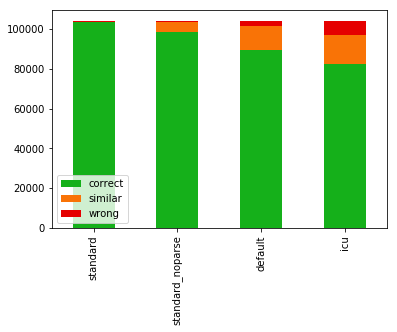

In [17]:
plot_diffs(known)

                 correct similar  wrong
standard           97.4%    0.0%   2.6%
standard_noparse   87.4%    9.8%   2.7%
default            68.6%   15.5%  15.8%
icu                15.0%   34.5%  50.5%


,correct,similar,wrong
standard,12865,4,343
standard_noparse,11551,1301,360
default,9070,2049,2093
icu,1983,4558,6671


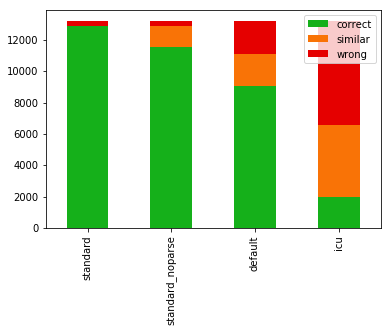

In [18]:
plot_diffs(known.query("default!=icu"))

In [19]:
known_similar.query("standard!=chrome & standard_noparse==chrome")[["standard", "standard_noparse", "chrome"]].sample()

,standard,standard_noparse,chrome
url,,,
http://lt.online-footballmanager.com/?action=&smID=cd000db029f6e2650487b76372fd80f6,UTF-8,windows-1252,windows-1252
